# CDMS Match Up Demo
Cloud-based Data Matchup Service (CDMS) allows users to collocate satellite to in situ and satellite to satellite data. 

In this notebook, the in situ data subsetting and match-up features will be demonstrated.

In [1]:
import requests
import json
import pandas as pd
import geopandas as gpd
from urllib.parse import urljoin, urlencode
from datetime import datetime
from time import sleep
import numpy as np

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D

import modules.cdms_reader as cdms_reader

### List available satellite and in situ datasets

In [2]:
response = requests.get("https://doms.jpl.nasa.gov/list").json()
pd.set_option('display.max_colwidth', None)
df = pd.DataFrame(response)[['title', 'iso_start', 'iso_end']]
df.sort_values('title')

,title,iso_start,iso_end
0,ASCATB-L2-Coastal,2015-06-30T23:51:00+0000,2019-01-01T00:02:58+0000
1,JPL-L4-MRVA-CHLA-GLOB-v3.0,2017-01-01T12:00:00+0000,2018-12-31T12:00:00+0000
2,MUR-JPL-L4-GLOB-v04.1,2019-01-16T09:00:00+0000,2019-08-05T09:00:00+0000
3,MUR25-JPL-L4-GLOB-v04.2,2017-01-01T09:00:00+0000,2023-08-03T09:00:00+0000
4,MUR25-JPL-L4-GLOB-v04.2_clim,1970-01-16T00:00:00+0000,1970-12-16T00:00:00+0000
5,OISSS_L4_multimission_7day_v1,2016-12-31T00:00:00+0000,2019-01-02T00:00:00+0000
6,SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL1812,1992-10-02T12:00:00+0000,2019-01-24T12:00:00+0000
7,SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5,2016-12-28T12:00:00+0000,2020-08-03T12:00:00+0000
8,VIIRS_NPP-2018_Heatwave,2018-07-01T09:05:55+0000,2018-09-30T22:01:22+0000


In [3]:
in_situ_list = []
# manually add in situ metadata to list 
in_situ_list.append({"title": "ICOADS Release 3.0", "iso_start": "2017-01-01T00:00:00+0000","iso_end": "2018-12-31T23:59:59+0000"})
in_situ_list.append({"title": "SAMOS", "iso_start": "2017-01-01T00:00:00+0000","iso_end": "2018-12-31T23:59:59+0000"})
in_situ_list.append({"title": "1021_atlantic", "iso_start": "2019-01-30T01:00:00+0000","iso_end": "2019-10-16T16:00:00+0000"})
in_situ_list.append({"title": "antarctic_circumnavigation_2019", "iso_start": "2019-01-19T00:00:00+0000","iso_end": "2020-08-15T00:00:00+0000"})
in_situ_list.append({"title": "atlantic_to_med_2019_to_2020", "iso_start": "2019-10-18T10:12:00+0000","iso_end": "2020-07-17T13:45:00+0000"})
in_situ_list.append({"title": "shark-2018", "iso_start": "2018-03-15T20:00:00+0000","iso_end": "2018-06-17T00:00:00+0000"})
in_situ_list.append({"title": "SPURS", "iso_start": "2011-10-19T19:09:00+0000","iso_end": "2019-03-11T23:42:00+0000"})

insitu_df = pd.DataFrame(in_situ_list)[['title', 'iso_start', 'iso_end']]
insitu_df

,title,iso_start,iso_end
0,ICOADS Release 3.0,2017-01-01T00:00:00+0000,2018-12-31T23:59:59+0000
1,SAMOS,2017-01-01T00:00:00+0000,2018-12-31T23:59:59+0000
2,1021_atlantic,2019-01-30T01:00:00+0000,2019-10-16T16:00:00+0000
3,antarctic_circumnavigation_2019,2019-01-19T00:00:00+0000,2020-08-15T00:00:00+0000
4,atlantic_to_med_2019_to_2020,2019-10-18T10:12:00+0000,2020-07-17T13:45:00+0000
5,shark-2018,2018-03-15T20:00:00+0000,2018-06-17T00:00:00+0000
6,SPURS,2011-10-19T19:09:00+0000,2019-03-11T23:42:00+0000


### Subset in situ dataset and plot

In [4]:
query_params = {
    'provider': 'Saildrone',
    'project': 'shark-2018',
    'startTime': '2018-04-01T00:00:00Z',
    'endTime': '2018-04-07T23:59:59Z',
    'bbox': '-180,-90,180,90',
    'platform': '3B',
    'minDepth': -5,
    'maxDepth': 5,
    'variable': 'mass_concentration_of_chlorophyll_in_sea_water',
    'columns': 'mass_concentration_of_chlorophyll_in_sea_water',
    'startIndex': 0,
    'itemsPerPage': 15000
}

In [5]:
in_situ_url = 'https://nasa-cdms.saildrone.com/insitu/1.0/query_data_doms_custom_pagination'
full_in_situ_url = f'{in_situ_url}?{urlencode(query_params)}'
print(full_in_situ_url)
response = requests.get(full_in_situ_url).json()
print(f'Total number of points returned {response["total"]}')
insitu_df = pd.DataFrame(response["results"])
insitu_df.head() # show first few records

https://nasa-cdms.saildrone.com/insitu/1.0/query_data_doms_custom_pagination?provider=Saildrone&project=shark-2018&startTime=2018-04-01T00%3A00%3A00Z&endTime=2018-04-07T23%3A59%3A59Z&bbox=-180%2C-90%2C180%2C90&platform=3B&minDepth=-5&maxDepth=5&variable=mass_concentration_of_chlorophyll_in_sea_water&columns=mass_concentration_of_chlorophyll_in_sea_water&startIndex=0&itemsPerPage=15000
Total number of points returned 10052


,mass_concentration_of_chlorophyll_in_sea_water,time,depth,latitude,longitude
0,0.09,2018-04-01T00:00:00Z,0.5,27.240928,-130.020352
1,0.09,2018-04-01T00:01:00Z,0.5,27.240611,-130.020339
2,0.09,2018-04-01T00:02:00Z,0.5,27.240314,-130.020326
3,0.09,2018-04-01T00:03:00Z,0.5,27.240077,-130.020326
4,0.10,2018-04-01T00:04:00Z,0.5,27.239830,-130.020301


<Axes: xlabel='longitude', ylabel='latitude'>

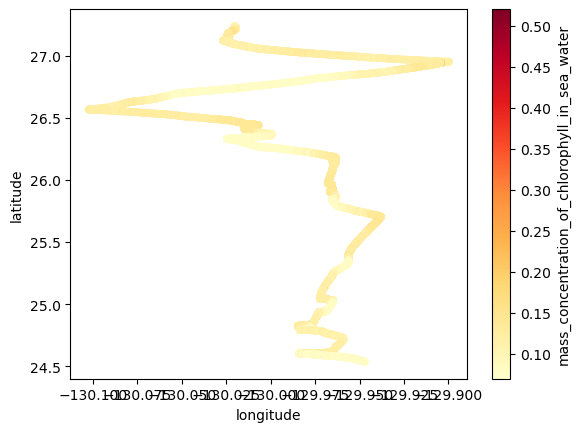

In [6]:
# Simple plot of data
insitu_df.plot(x='longitude', y='latitude', kind='scatter', c='mass_concentration_of_chlorophyll_in_sea_water', colormap='YlOrRd')


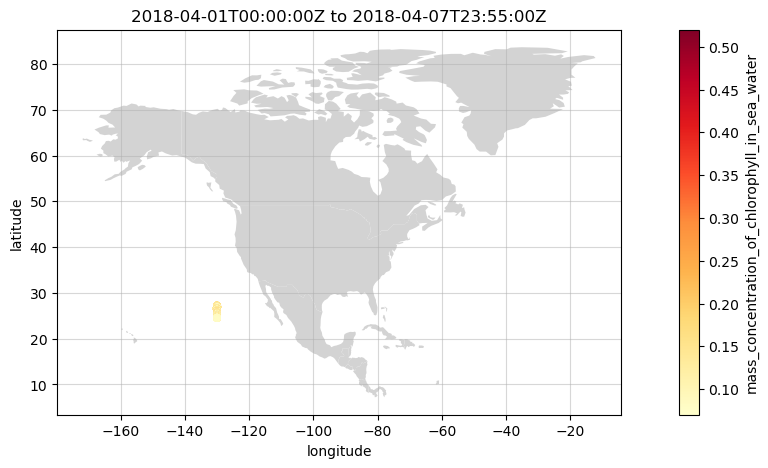

In [7]:
# Plot with a map 

# initialize an axis
fig, ax = plt.subplots(figsize=(15,5))

# plot map on axis
countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#print(countries)
countries[countries['continent'] == 'North America'].plot(color='lightgrey', ax=ax)

# parse dates for plot's title
first = insitu_df['time'].min()
last = insitu_df['time'].max()

# plot points
insitu_df.plot(x='longitude', y='latitude', kind='scatter', 
        c='mass_concentration_of_chlorophyll_in_sea_water', colormap='YlOrRd', 
        title=f'{first} to {last}', 
        ax=ax)

# add grid
ax.grid(alpha=0.5)
plt.show()


### Run satellite to in situ matchup query
Match JPL-L4-MRVA-CHLA-GLOB-v3.0 with Saildrone White Shark Café

In [8]:
matchup_url = 'https://doms.jpl.nasa.gov/match_spark'

In [9]:
def execute_matchup_request(query_params, in_situ_variable_name=None):
    TIMEOUT = 15 * 60
    full_matchup_url = f'{matchup_url}?{urlencode(query_params)}'
    print(full_matchup_url)
    
    response = requests.get(full_matchup_url)
    response_json = response.json()
    
    start = datetime.utcnow()
    job_url = [link for link in response_json['links'] if link['rel'] == 'self'][0]['href']
    job_id = response_json['executionID']
    print(f'Execution ID: {job_id}')

    while response_json['status'] == 'running' and (datetime.utcnow() - start).total_seconds() <= TIMEOUT:
        status_response = requests.get(job_url)
        response_json = status_response.json()

        if response_json['status'] == 'running':
            sleep(10)

    job_status = response_json['status']

    if job_status == 'running':
        print(f'Job {job_id} has been running too long, will not wait anymore')
    elif job_status in ['cancelled', 'failed']:
        raise ValueError(f'Async matchup job finished with incomplete status ({job_status})')
    else:
        results_url = [
            link for link in response_json['links'] if 'output=JSON' in link['href']
            # link for link in response_json['links'] if link['type'] == 'application/json'
        ][0]['href']

        results_response = requests.get(results_url + "&pageSize=10000").json()
        
    primary_points = []
    secondary_points = []
    for primary_point in results_response['data']:
        for variable in primary_point['matches'][0]['secondary']:
            if in_situ_variable_name:
                if variable['variable_name'] == in_situ_variable_name:
                    primary_points.append((float(primary_point['lon']), float(primary_point['lat']), float(primary_point['primary'][0]['variable_value'])))
                    secondary_points.append((float(primary_point['matches'][0]['lon']), float(primary_point['matches'][0]['lat']), float(variable['variable_value'])))
            else:
                # pick the first variable
                primary_points.append((float(primary_point['lon']), float(primary_point['lat']), float(primary_point['primary'][0]['variable_value'])))
                secondary_points.append((float(primary_point['matches'][0]['lon']), float(primary_point['matches'][0]['lat']), float(variable['variable_value'])))
                break
    print(f'Total number of primary matched points {len(primary_points)}')
    print(f'Total number of secondary matched points {len(secondary_points)}')
    return primary_points, secondary_points, job_id

In [10]:
query_params = {
    'primary': 'JPL-L4-MRVA-CHLA-GLOB-v3.0',
    'secondary': 'shark-2018',
    'startTime': '2018-04-01T00:00:00Z',
    'endTime': '2018-04-01T23:59:59Z',
    'tt': 86400,  # Time tolerance in seconds
    'rt': 50000,  # Spatial tolerance in meters
    'b': '-140,10,-110,40',
    'platforms': '3B',
    'parameter': 'mass_concentration_of_chlorophyll_in_sea_water',
    'depthMin': -5,
    'depthMax': 5,
    'matchOnce': 'true'
}

In [11]:
primary_points, secondary_points, execution_id = execute_matchup_request(query_params, query_params['parameter'])

https://doms.jpl.nasa.gov/match_spark?primary=JPL-L4-MRVA-CHLA-GLOB-v3.0&secondary=shark-2018&startTime=2018-04-01T00%3A00%3A00Z&endTime=2018-04-01T23%3A59%3A59Z&tt=86400&rt=50000&b=-140%2C10%2C-110%2C40&platforms=3B&parameter=mass_concentration_of_chlorophyll_in_sea_water&depthMin=-5&depthMax=5&matchOnce=true
Execution ID: 12847bdd-9a46-477d-b3c1-4e57e74cb428
Total number of primary matched points 27
Total number of secondary matched points 27


In [12]:
def plot_points(primary_points, secondary_points):
    plt.figure(figsize=(20,5), dpi=500) 
    min_lon = min([point[0] for point in primary_points])
    max_lon = max([point[0] for point in primary_points])
    min_lat = min([point[1] for point in primary_points])
    max_lat = min([point[1] for point in primary_points])
    basemap = Basemap(
        projection='mill',
        lon_0=180,
        llcrnrlat=min_lat - 50,
        urcrnrlat=max_lat + 50,
        llcrnrlon=min_lon - 50,
        urcrnrlon=max_lon + 50
    )
    basemap.drawlsmask(
        land_color='lightgrey',
        ocean_color='white',
        lakes=True
    )

    # transform coordinates
    x1, y1 = basemap([point[0] for point in primary_points], [point[1] for point in primary_points])  
    x2, y2 = basemap([point[0] for point in secondary_points], [point[1] for point in secondary_points])
    
    # Draw scatter points
    plt.scatter(x2, y2, 10, marker='o', color='Blue', label='Primary point')
    plt.scatter(x1, y1, 10, marker='*', color='Green', label='Secondary point')

    # transform input bbox
    bx, by = basemap([-140, -110], [40, 10])  
    
    # Draw user provided bounds
    plt.gca().add_patch(patches.Rectangle(
        (bx[0], by[1]), abs(bx[0] - bx[1]), abs(by[0] - by[1]), 
        linewidth=1, 
        edgecolor='r', 
        facecolor='none'
    ))
    
    # Show legend
    handles, labels = plt.gca().get_legend_handles_labels()
    bbox_legend = Line2D(
        [0], [0], 
        color='red', 
        linewidth=1, 
        linestyle='-', 
        label='User search domain'
    )
    handles.append(bbox_legend)
    plt.legend(loc='upper left', handles=handles)
    
    plt.show()

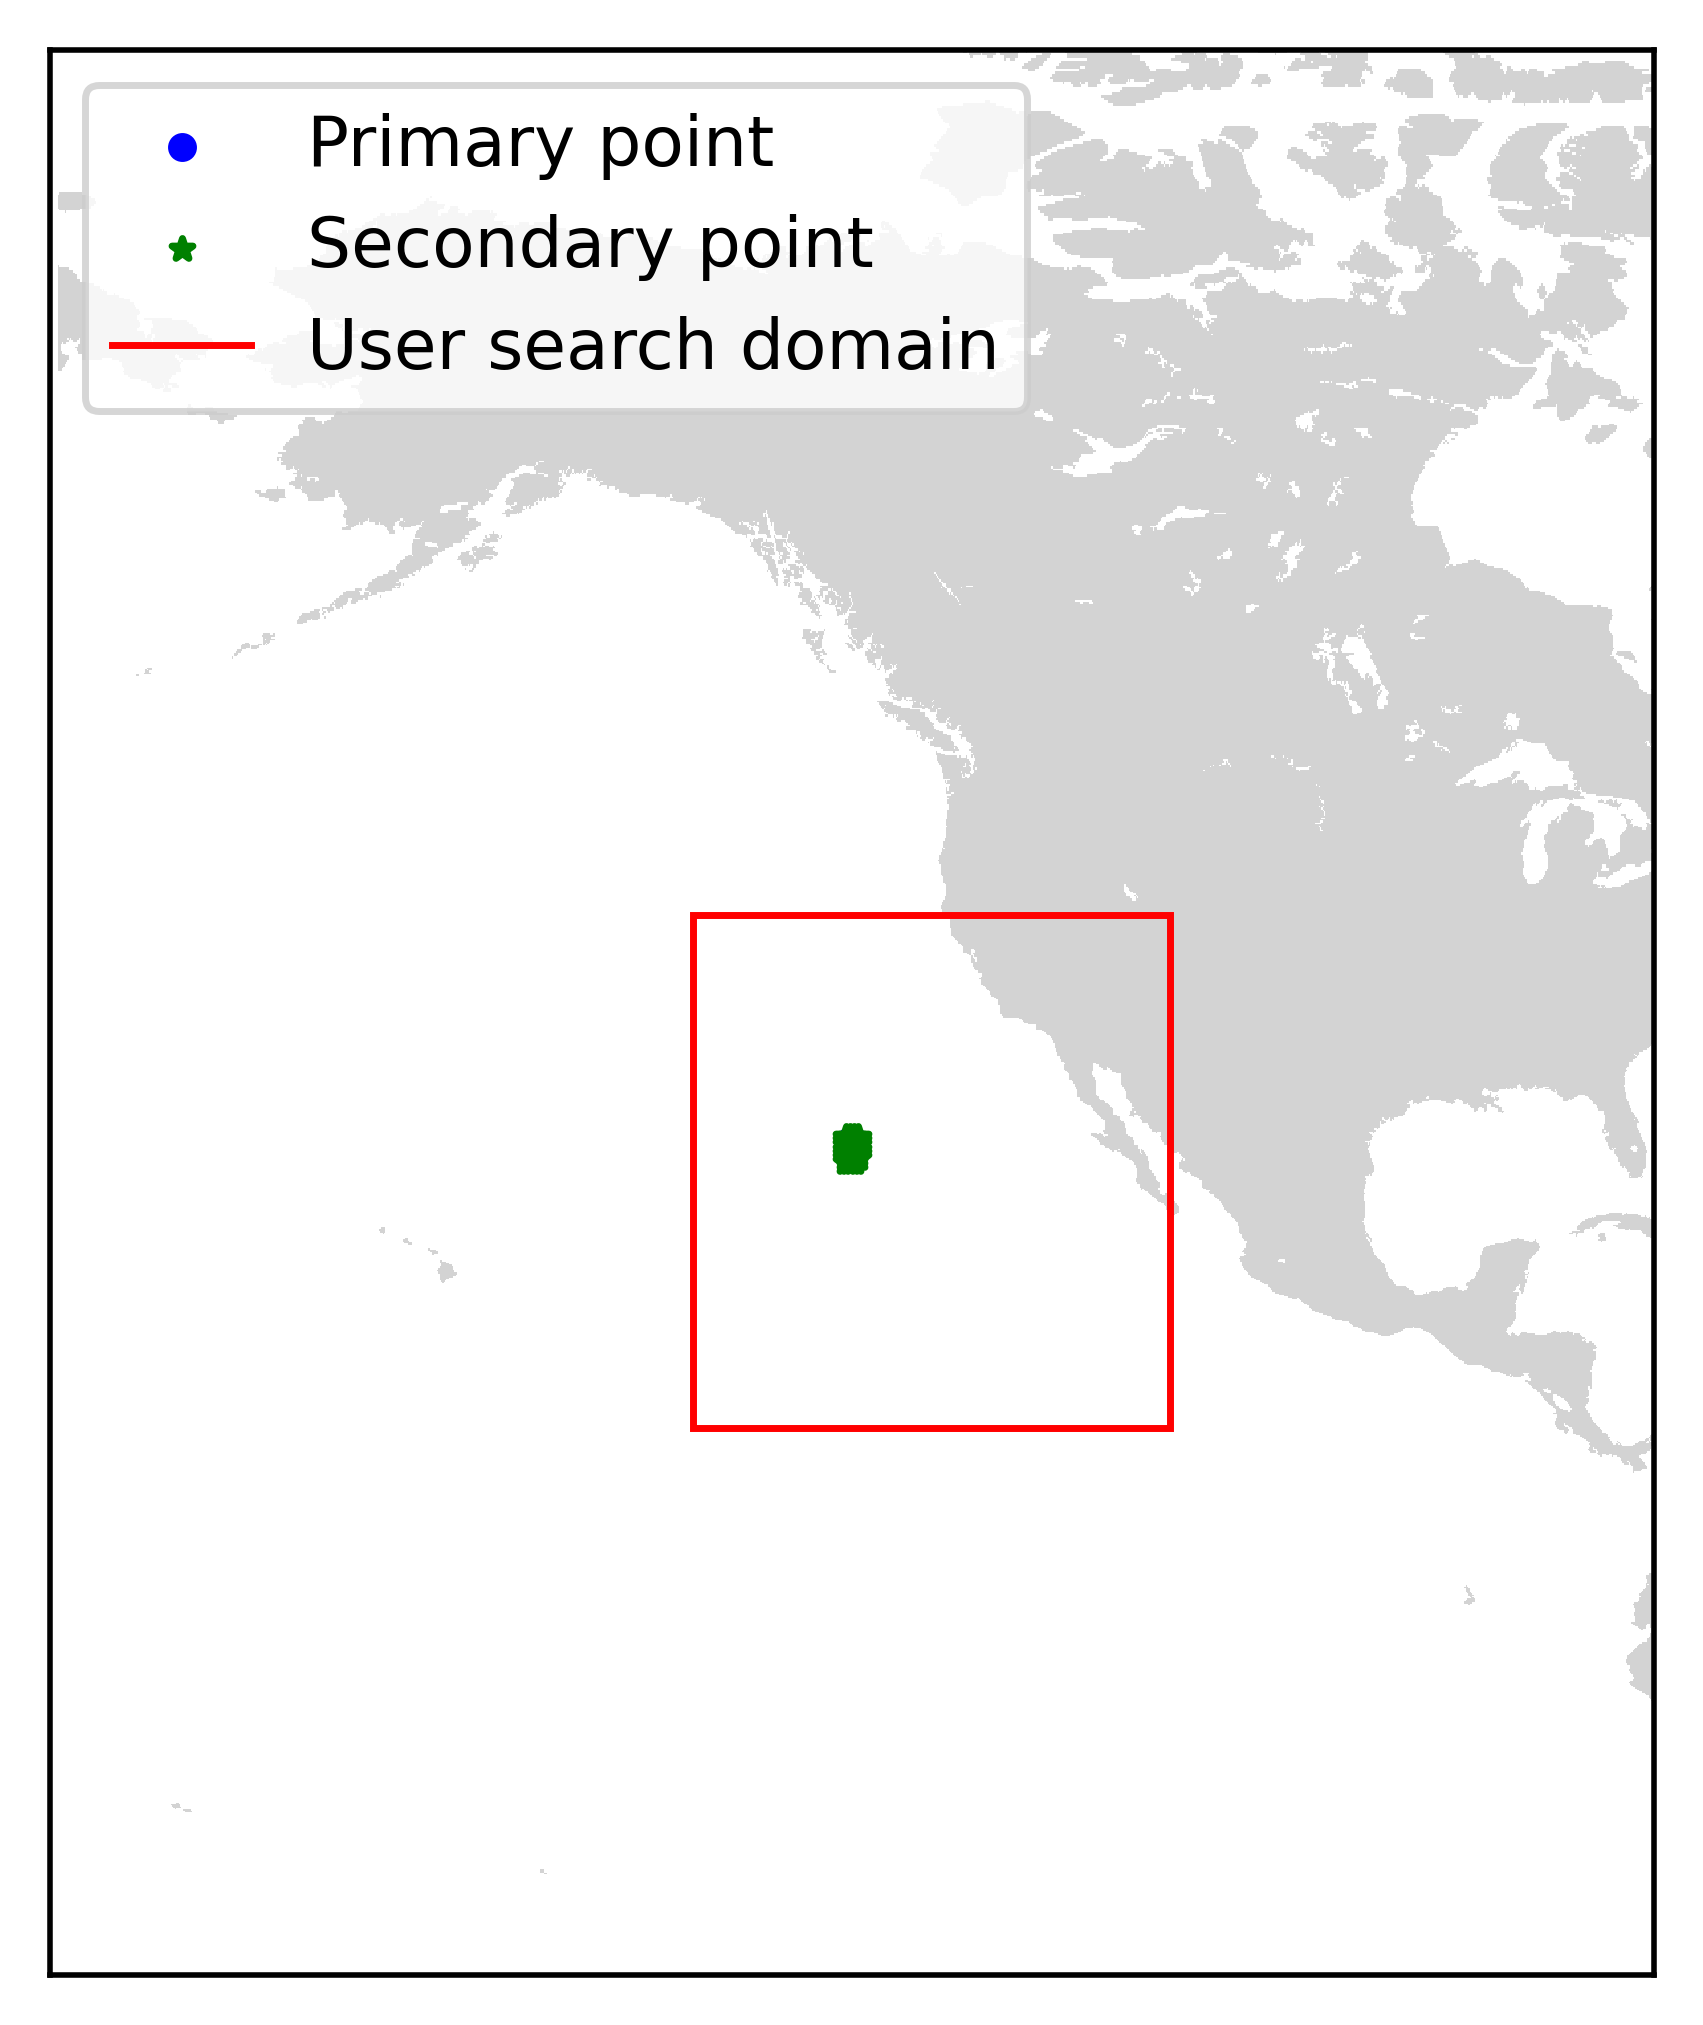

In [13]:
plot_points(primary_points, secondary_points)

In [14]:
def generate_diff_plot(primary_points, secondary_points, primary_name, secondary_name, units):
    diffs = [primary_point[2] - secondary_point[2] for primary_point, secondary_point in zip(primary_points, secondary_points)]
    
    plt.figure(figsize=(20,5), dpi=500) 
    min_lon = min([point[0] for point in primary_points])
    max_lon = max([point[0] for point in primary_points])
    min_lat = min([point[1] for point in primary_points])
    max_lat = min([point[1] for point in primary_points])
    basemap = Basemap(
        projection='mill',
        lon_0=180,
        llcrnrlat=min_lat - 10,
        urcrnrlat=max_lat + 10,
        llcrnrlon=min_lon - 10,
        urcrnrlon=max_lon + 10
    )
    basemap.drawlsmask(
        land_color='lightgrey',
        ocean_color='white',
        lakes=True
    )

    # transform coordinates
    x1, y1 = basemap([point[0] for point in primary_points], [point[1] for point in primary_points])  
    x2, y2 = basemap([point[0] for point in secondary_points], [point[1] for point in secondary_points])
    
    # Customize colormap/colorbar
    cmap = plt.cm.coolwarm
    # Draw scatter points
    sc = plt.scatter(x2, y2, 30, marker='o', c=diffs, alpha=0.7, cmap=cmap)

    cb = plt.colorbar(sc)
    cb.ax.set_title(units,fontsize=8)        
    plt.title(f'Difference plot between {primary_name} and {secondary_name}')

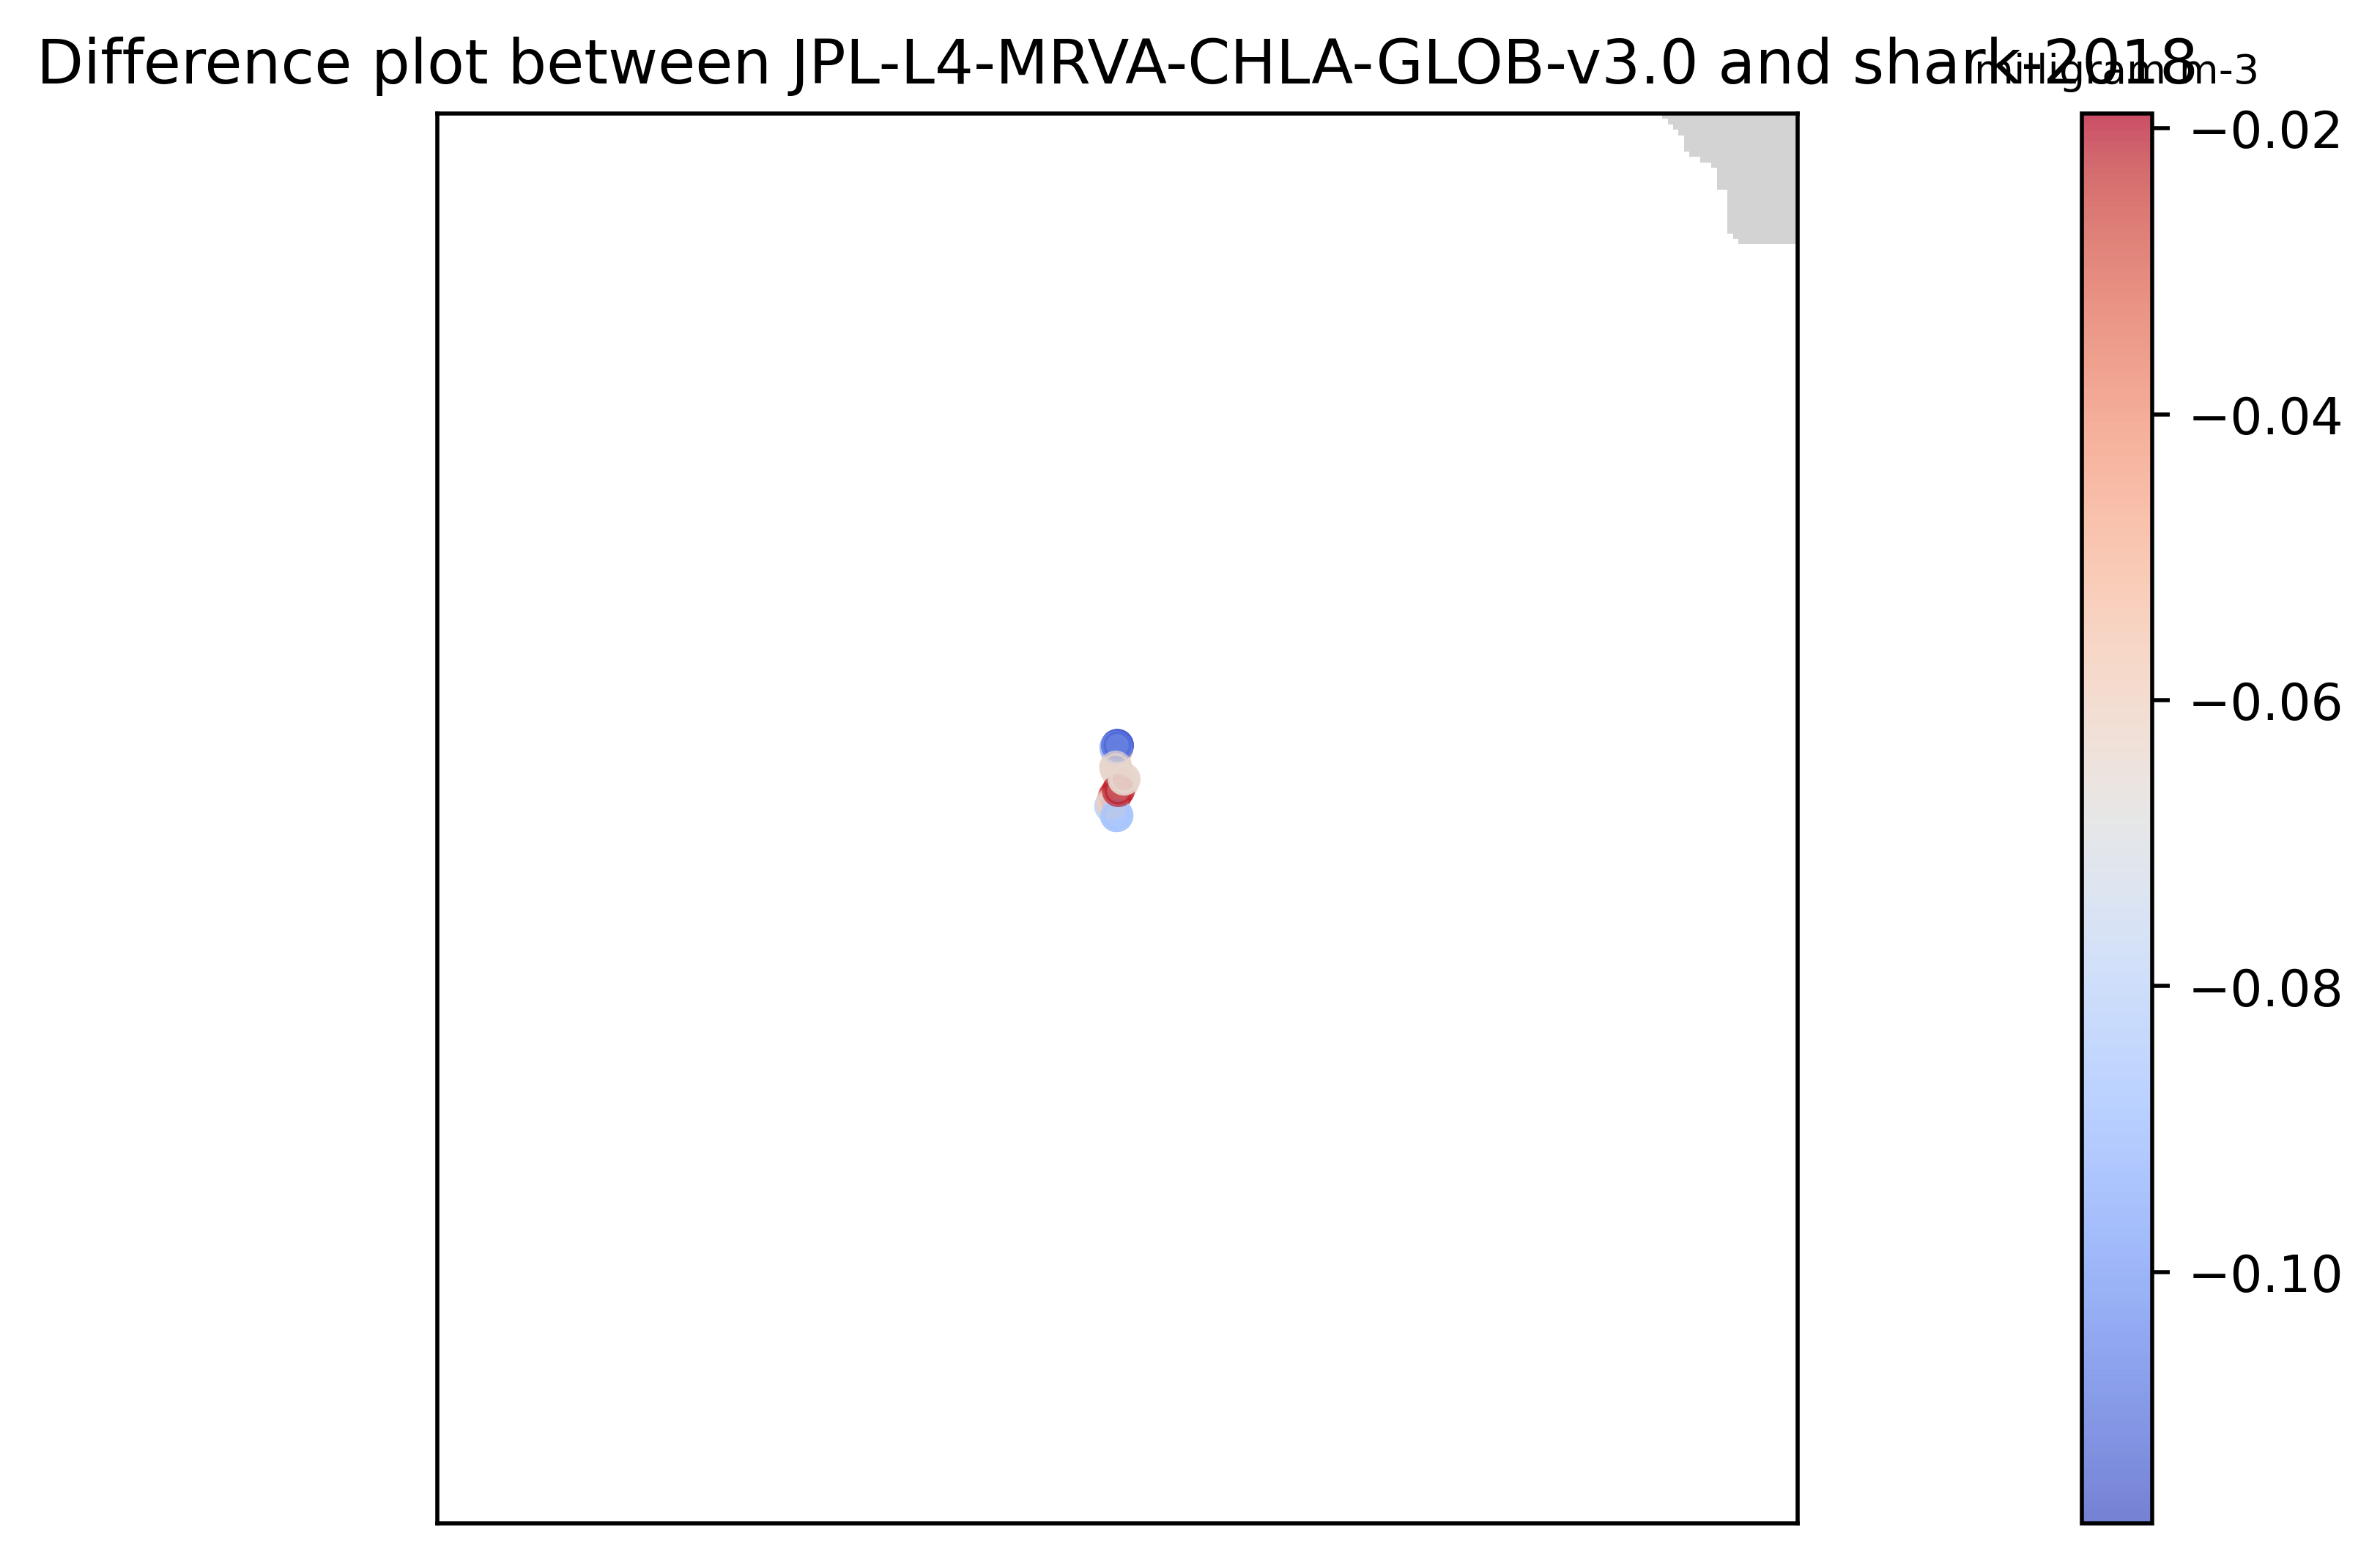

In [15]:
generate_diff_plot(primary_points, secondary_points, query_params['primary'], query_params['secondary'], 'milligram m-3')

### Run satellite to in situ matchup query

Match MUR25-JPL-L4-GLOB-v04.2 with ICOADS Release 3.0

In [16]:
query_params = {
    'primary': 'MUR25-JPL-L4-GLOB-v04.2',
    'secondary': 'ICOADS_JPL',
    'startTime': '2018-04-01T00:00:00Z',
    'endTime': '2018-04-01T23:59:59Z',
    'tt': 86400,  # Time tolerance in seconds
    'rt': 50000,  # Spatial tolerance in meters
    'b': '-140,10,-110,40',
    'platforms': '42',
    'parameter': 'sea_water_temperature',
    'depthMin': -5,
    'depthMax': 5,
    'matchOnce': 'true'
}

primary_points, secondary_points, execution_id = execute_matchup_request(query_params, query_params['parameter'])

https://doms.jpl.nasa.gov/match_spark?primary=MUR25-JPL-L4-GLOB-v04.2&secondary=ICOADS_JPL&startTime=2018-04-01T00%3A00%3A00Z&endTime=2018-04-01T23%3A59%3A59Z&tt=86400&rt=50000&b=-140%2C10%2C-110%2C40&platforms=42&parameter=sea_water_temperature&depthMin=-5&depthMax=5&matchOnce=true
Execution ID: 2da0e843-c6bb-46a9-b776-d4fecb3e25ea
Total number of primary matched points 698
Total number of secondary matched points 698


In [17]:
def fetch_result(execution_id, output_format, output_file, primary_variable, secondary_variable):
    match_up_results_csv = f'{output_file}.csv'
    response = requests.get("https://doms.jpl.nasa.gov/cdmsresults", params={"id": execution_id, "output": output_format, "pageSize": 10000})
    with open(output_file, mode='wb') as f:
        f.write(response.content)

    matches = cdms_reader.assemble_matches(output_file)

    cdms_reader.matches_to_csv(matches, match_up_results_csv)
    
    columns_to_include = ["PrimaryData_lon", "PrimaryData_lat", "PrimaryData_datetime", "SecondaryData_lon", "SecondaryData_lat", "SecondaryData_datetime"]
    for variable in primary_variable:
        columns_to_include.append(f'PrimaryData_{variable}')
    for variable in secondary_variable:
        columns_to_include.append(f'SecondaryData_{variable}')
    return pd.read_csv(match_up_results_csv, usecols=columns_to_include)

In [18]:
df = fetch_result(execution_id, "NETCDF", "mur_to_icoads_results.nc", ["sea_surface_foundation_temperature"], ["sea_water_temperature"])
df

,PrimaryData_lon,PrimaryData_lat,PrimaryData_sea_surface_foundation_temperature,PrimaryData_datetime,SecondaryData_lon,SecondaryData_lat,SecondaryData_sea_water_temperature,SecondaryData_datetime
0,-124.625,20.375,23.037994,2018-04-01 08:59:44,-124.36,20.57,22.82,2018-03-31 08:59:44
1,-127.875,28.375,18.632996,2018-04-01 08:59:44,-128.16,28.69,17.80,2018-04-01 09:10:24
2,-117.625,17.125,25.522003,2018-04-01 08:59:44,-117.40,16.96,25.70,2018-03-31 16:00:00
3,-128.375,29.125,18.036987,2018-04-01 08:59:44,-128.22,28.81,17.48,2018-03-31 13:09:20
4,-122.375,23.875,20.316986,2018-04-01 08:59:44,-122.23,23.53,21.04,2018-03-31 09:59:28
...,...,...,...,...,...,...,...,...
693,-116.375,12.625,27.832000,2018-04-01 08:59:44,-116.23,12.48,27.39,2018-04-01 10:59:12
694,-139.125,15.375,26.059998,2018-04-01 08:59:44,-139.44,15.55,26.08,2018-04-01 00:32:00
695,-139.375,22.375,22.520996,2018-04-01 08:59:44,-139.22,22.51,22.63,2018-04-01 19:29:04
696,-139.625,15.125,26.118988,2018-04-01 08:59:44,-139.49,15.53,25.98,2018-03-31 08:59:44


In [19]:
def generate_scatter_plot(primary_points, secondary_points, primary_name, secondary_name, variable_name, units):
    x = np.array([point[2] for point in secondary_points])
    y = np.array([point[2] for point in primary_points])
    m, b = np.polyfit(x, y, 1)
    fig, ax = plt.subplots()
    ax.set_title(f'{variable_name} scatter\n{primary_name} vs. {secondary_name}')
    ax.set_xlabel("%s %s" % (secondary_name, units))
    ax.set_ylabel("%s %s" % (primary_name, units))
    ax.scatter(x, y)
    ax.plot(x, m*x+b);
    ax.plot([0,1],[0,1], transform=ax.transAxes)

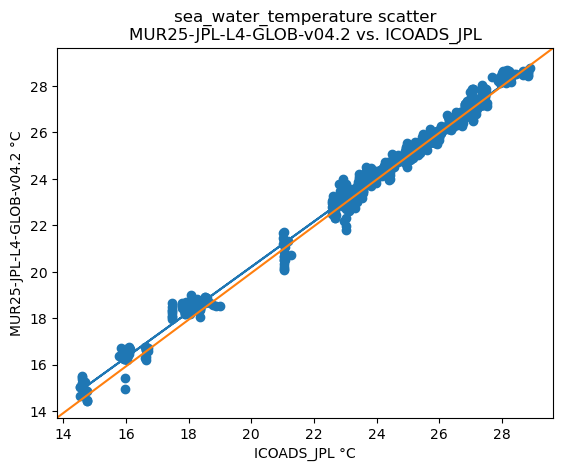

In [20]:
generate_scatter_plot(primary_points, secondary_points, query_params['primary'], query_params['secondary'], query_params['parameter'], '°C')

### Run satellite to in situ matchup query

Match ASCATB-L2-Coastal with SAMOS


In [21]:
query_params = {
    'primary': 'ASCATB-L2-Coastal',
    'secondary': 'SAMOS',
    'startTime': '2017-05-01T00:00:00Z',
    'endTime': '2017-05-04T23:59:59Z',
    'tt': 43200,  # Time tolerance in seconds
    'rt': 50000,  # Spatial tolerance in meters
    'b': '-100,20,-90,30',
    'platforms': '30',
    'parameter': 'wind_speed',
    'depthMin': -10,
    'depthMax': 10,
    'matchOnce': 'true'
}

primary_points, secondary_points, execution_id = execute_matchup_request(query_params, query_params["parameter"])

https://doms.jpl.nasa.gov/match_spark?primary=ASCATB-L2-Coastal&secondary=SAMOS&startTime=2017-05-01T00%3A00%3A00Z&endTime=2017-05-04T23%3A59%3A59Z&tt=43200&rt=50000&b=-100%2C20%2C-90%2C30&platforms=30&parameter=wind_speed&depthMin=-10&depthMax=10&matchOnce=true
Execution ID: 790b15f2-97d3-4adc-9ab4-e935f47cd4f9
Total number of primary matched points 163
Total number of secondary matched points 163


In [22]:
df = fetch_result(execution_id, "NETCDF", "ascat_to_samos_results.nc", [query_params["parameter"]], [query_params["parameter"], "depth"])
df

,PrimaryData_lon,PrimaryData_lat,PrimaryData_wind_speed,PrimaryData_datetime,SecondaryData_lon,SecondaryData_lat,SecondaryData_depth,SecondaryData_wind_speed,SecondaryData_datetime
0,-92.91141,27.68912,10.28,2017-05-03 15:40:48,-93.1547,27.9241,-99999.0,10.8,2017-05-03 10:22:56
1,-93.42648,28.94365,1.38,2017-05-01 16:21:20,-93.8188,28.7876,-99999.0,11.5,2017-05-02 03:24:48
2,-93.27872,27.72268,8.28,2017-05-04 02:54:56,-93.2736,27.8663,-99999.0,7.2,2017-05-03 22:17:36
3,-93.25211,28.66405,2.08,2017-05-01 16:21:20,-93.7323,28.6290,-99999.0,10.4,2017-05-02 04:20:16
4,-93.52350,28.47485,8.69,2017-05-03 15:38:40,-93.2592,28.1035,-99999.0,7.1,2017-05-04 00:00:00
...,...,...,...,...,...,...,...,...,...
158,-93.64362,27.62325,7.87,2017-05-04 02:54:56,-93.3018,27.8766,-99999.0,8.3,2017-05-03 18:20:48
159,-92.82217,28.32290,6.87,2017-05-04 02:54:56,-93.2592,28.1035,-99999.0,7.1,2017-05-04 00:00:00
160,-93.55661,27.76219,8.20,2017-05-04 02:54:56,-93.3020,27.8769,-99999.0,9.2,2017-05-03 18:18:40
161,-93.60666,27.51895,7.52,2017-05-04 02:54:56,-93.3018,27.8766,-99999.0,8.3,2017-05-03 18:20:48


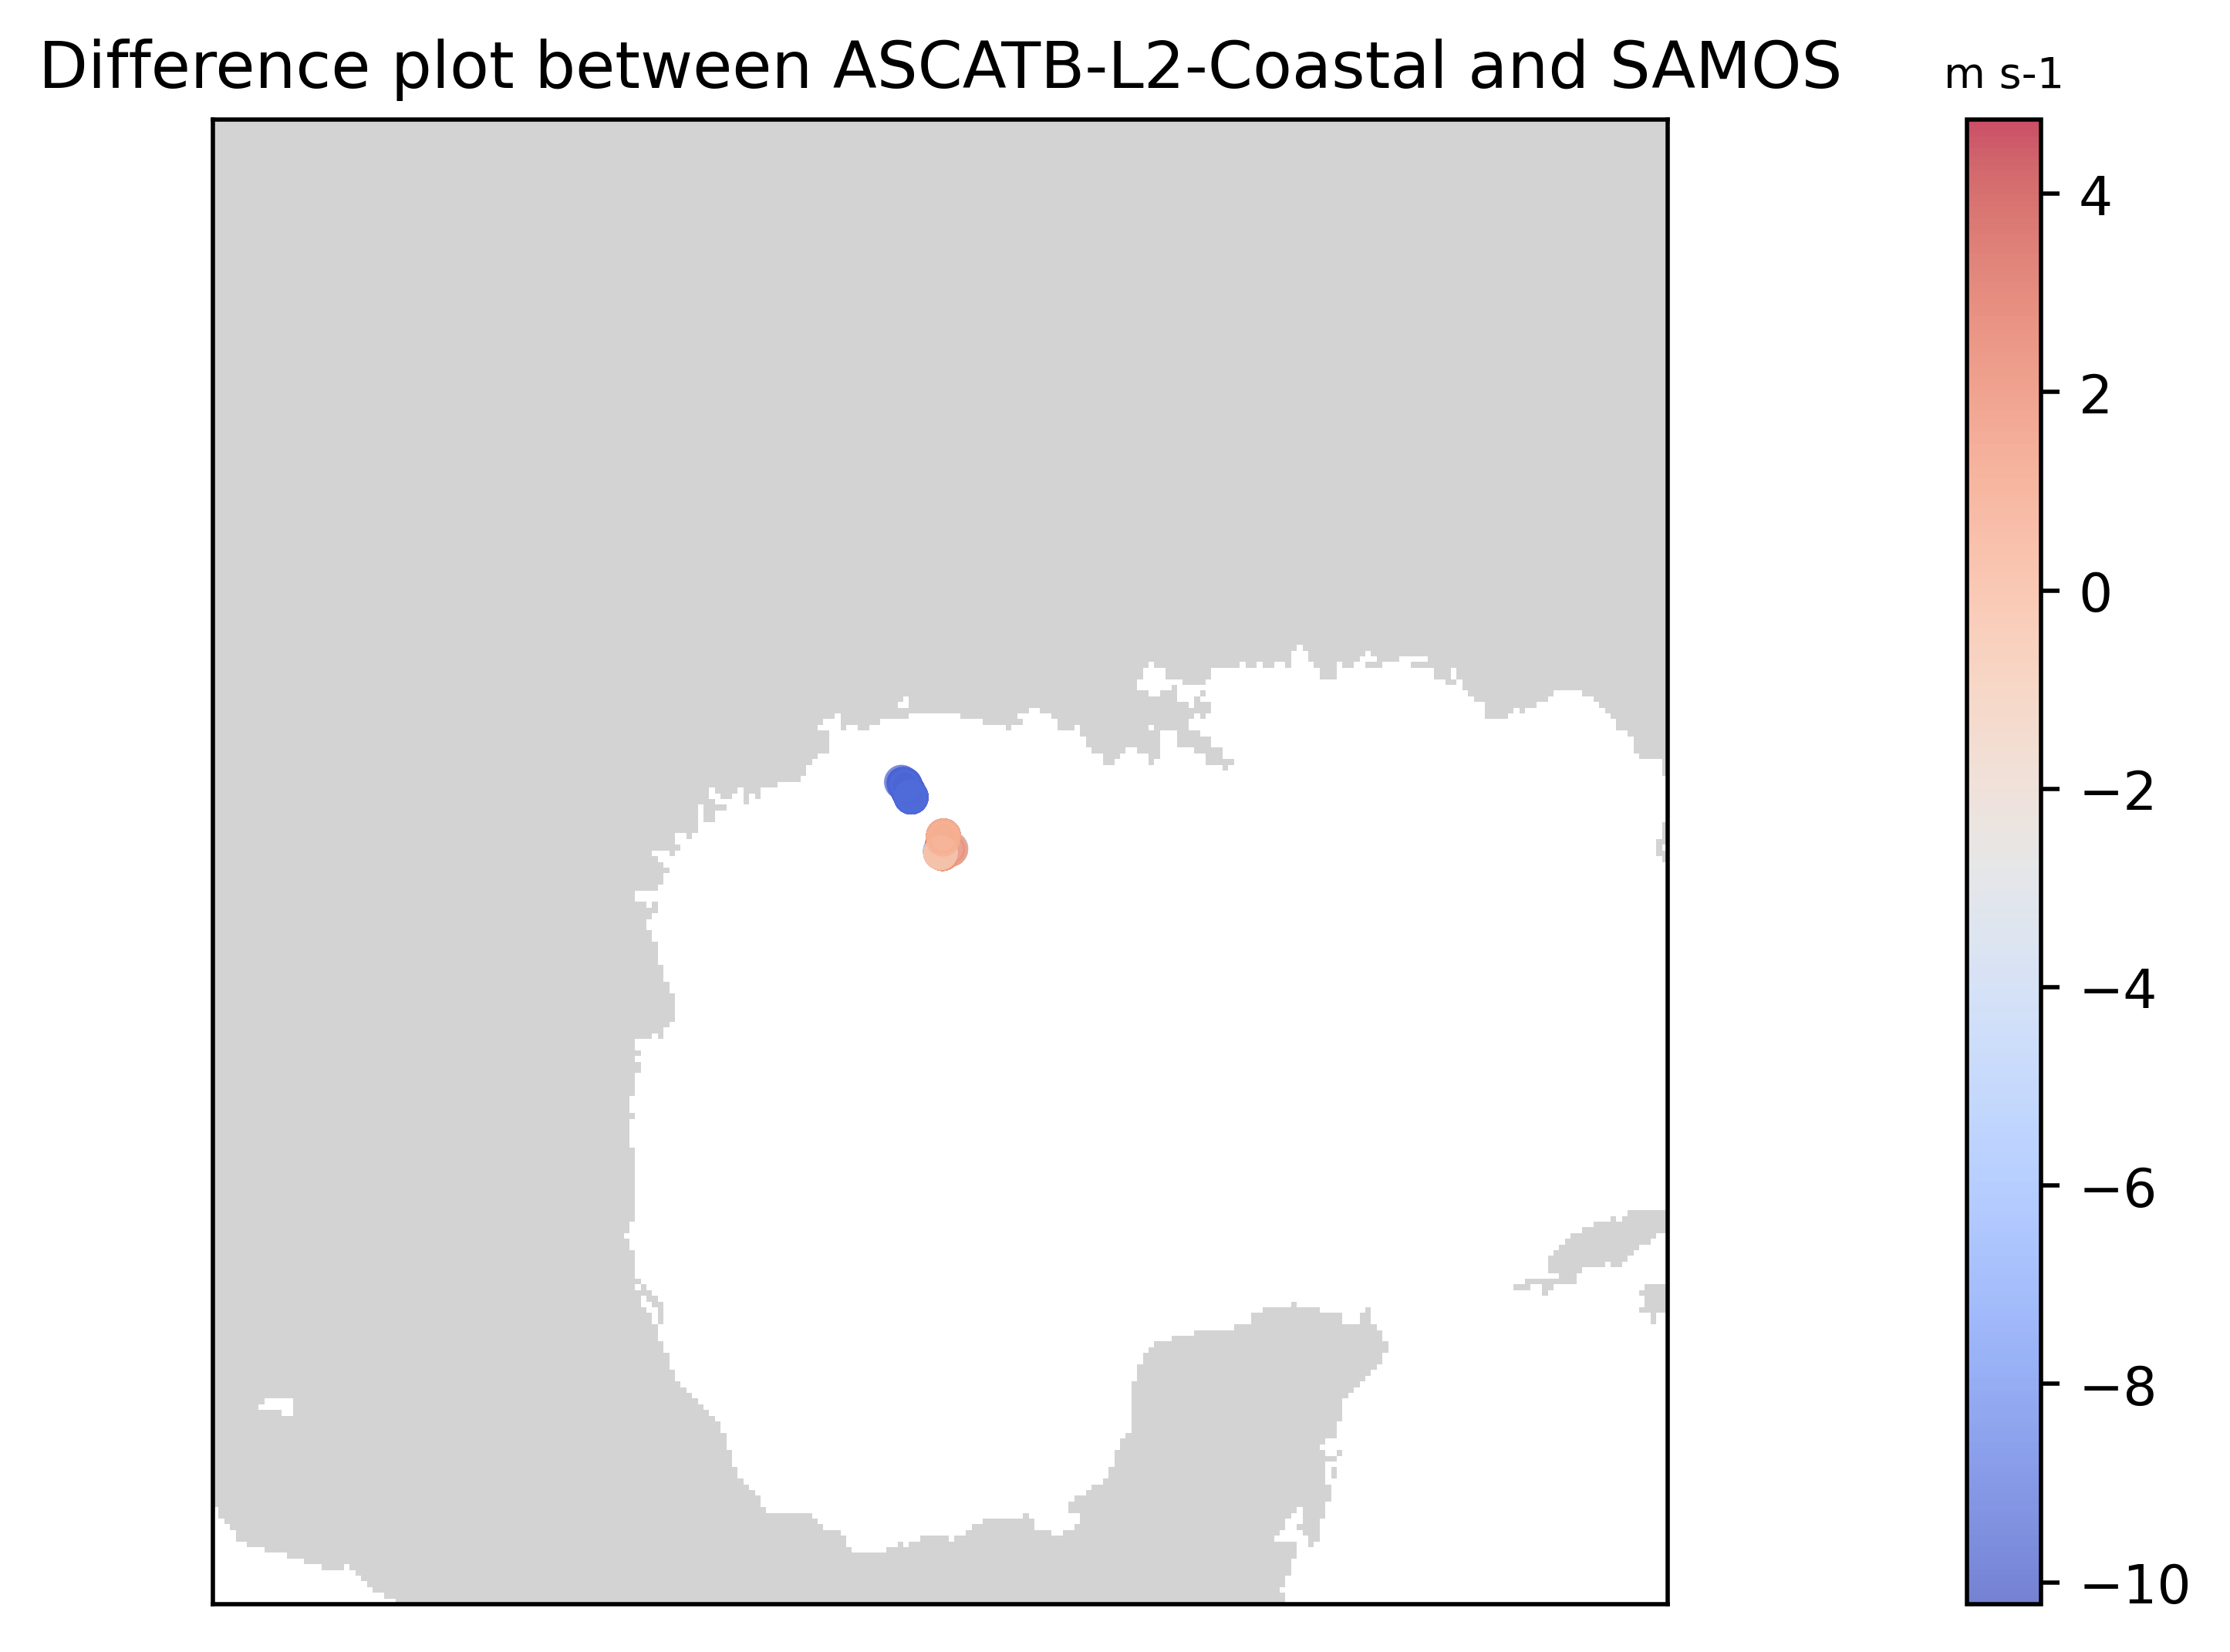

In [23]:
generate_diff_plot(primary_points, secondary_points, query_params['primary'], query_params['secondary'], 'm s-1')

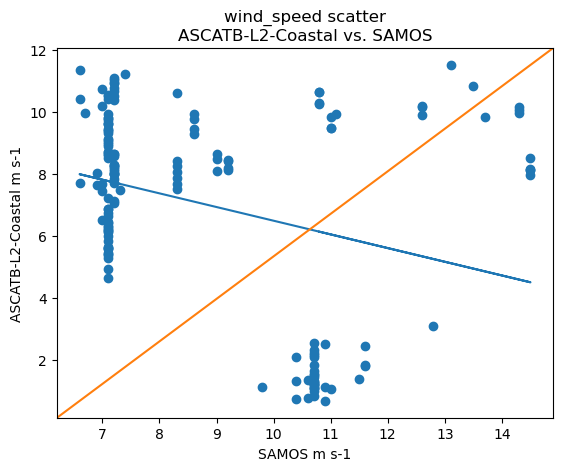

In [24]:
generate_scatter_plot(primary_points, secondary_points, query_params['primary'], query_params['secondary'], query_params['parameter'], 'm s-1')

### Run satellite to satellite matchup query
Match SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5 with OISSS_L4_multimission_7day_v1

In [25]:
query_params = {
    'primary': 'SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5',
    'secondary': 'OISSS_L4_multimission_7day_v1',
    'startTime': '2018-08-01T00:00:00Z',
    'endTime': '2018-08-02T00:00:00Z',
    'tt': 604800,  # Time tolerance in seconds
    'rt': 50000,  # Spatial tolerance in meters
    'b': '-100,20,-90,30',
    'platforms': '65',
    'parameter': 'sea_surface_salinity',
    'depthMin': -20,
    'depthMax': 10,
    'matchOnce': 'true'
}

primary_points, secondary_points, execution_id = execute_matchup_request(query_params)

https://doms.jpl.nasa.gov/match_spark?primary=SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5&secondary=OISSS_L4_multimission_7day_v1&startTime=2018-08-01T00%3A00%3A00Z&endTime=2018-08-02T00%3A00%3A00Z&tt=604800&rt=50000&b=-100%2C20%2C-90%2C30&platforms=65&parameter=sea_surface_salinity&depthMin=-20&depthMax=10&matchOnce=true
Execution ID: be9fdee7-41bd-4aec-b4b7-1d382e23fd45
Total number of primary matched points 1058
Total number of secondary matched points 1058


In [26]:
df = fetch_result(execution_id, "NETCDF", "smap_sss_to_oisss_results.nc", [query_params['parameter']], [query_params['parameter']])
df

,PrimaryData_lon,PrimaryData_lat,PrimaryData_sea_surface_salinity,PrimaryData_datetime,SecondaryData_lon,SecondaryData_lat,SecondaryData_sea_surface_salinity,SecondaryData_datetime
0,-93.375,27.375,36.537910,2018-08-01 12:01:04,-93.375,27.375,36.065020,2018-08-03 00:00:00
1,-91.625,24.125,35.588670,2018-08-01 12:01:04,-91.625,24.125,35.961803,2018-08-03 00:00:00
2,-97.125,23.125,36.542267,2018-08-01 12:01:04,-97.125,23.125,36.492283,2018-08-03 00:00:00
3,-92.625,22.875,36.522870,2018-08-01 12:01:04,-92.625,22.875,36.344097,2018-08-03 00:00:00
4,-90.125,26.625,31.621685,2018-08-01 12:01:04,-90.125,26.625,35.209667,2018-08-03 00:00:00
...,...,...,...,...,...,...,...,...
1053,-94.625,24.125,36.529390,2018-08-01 12:01:04,-94.625,24.125,36.512940,2018-08-03 00:00:00
1054,-94.875,20.125,36.401665,2018-08-01 12:01:04,-94.875,20.125,36.404896,2018-08-03 00:00:00
1055,-96.625,24.875,36.053257,2018-08-01 12:01:04,-96.625,24.875,36.407670,2018-08-03 00:00:00
1056,-94.625,26.375,36.635735,2018-08-01 12:01:04,-94.625,26.375,36.422340,2018-08-03 00:00:00


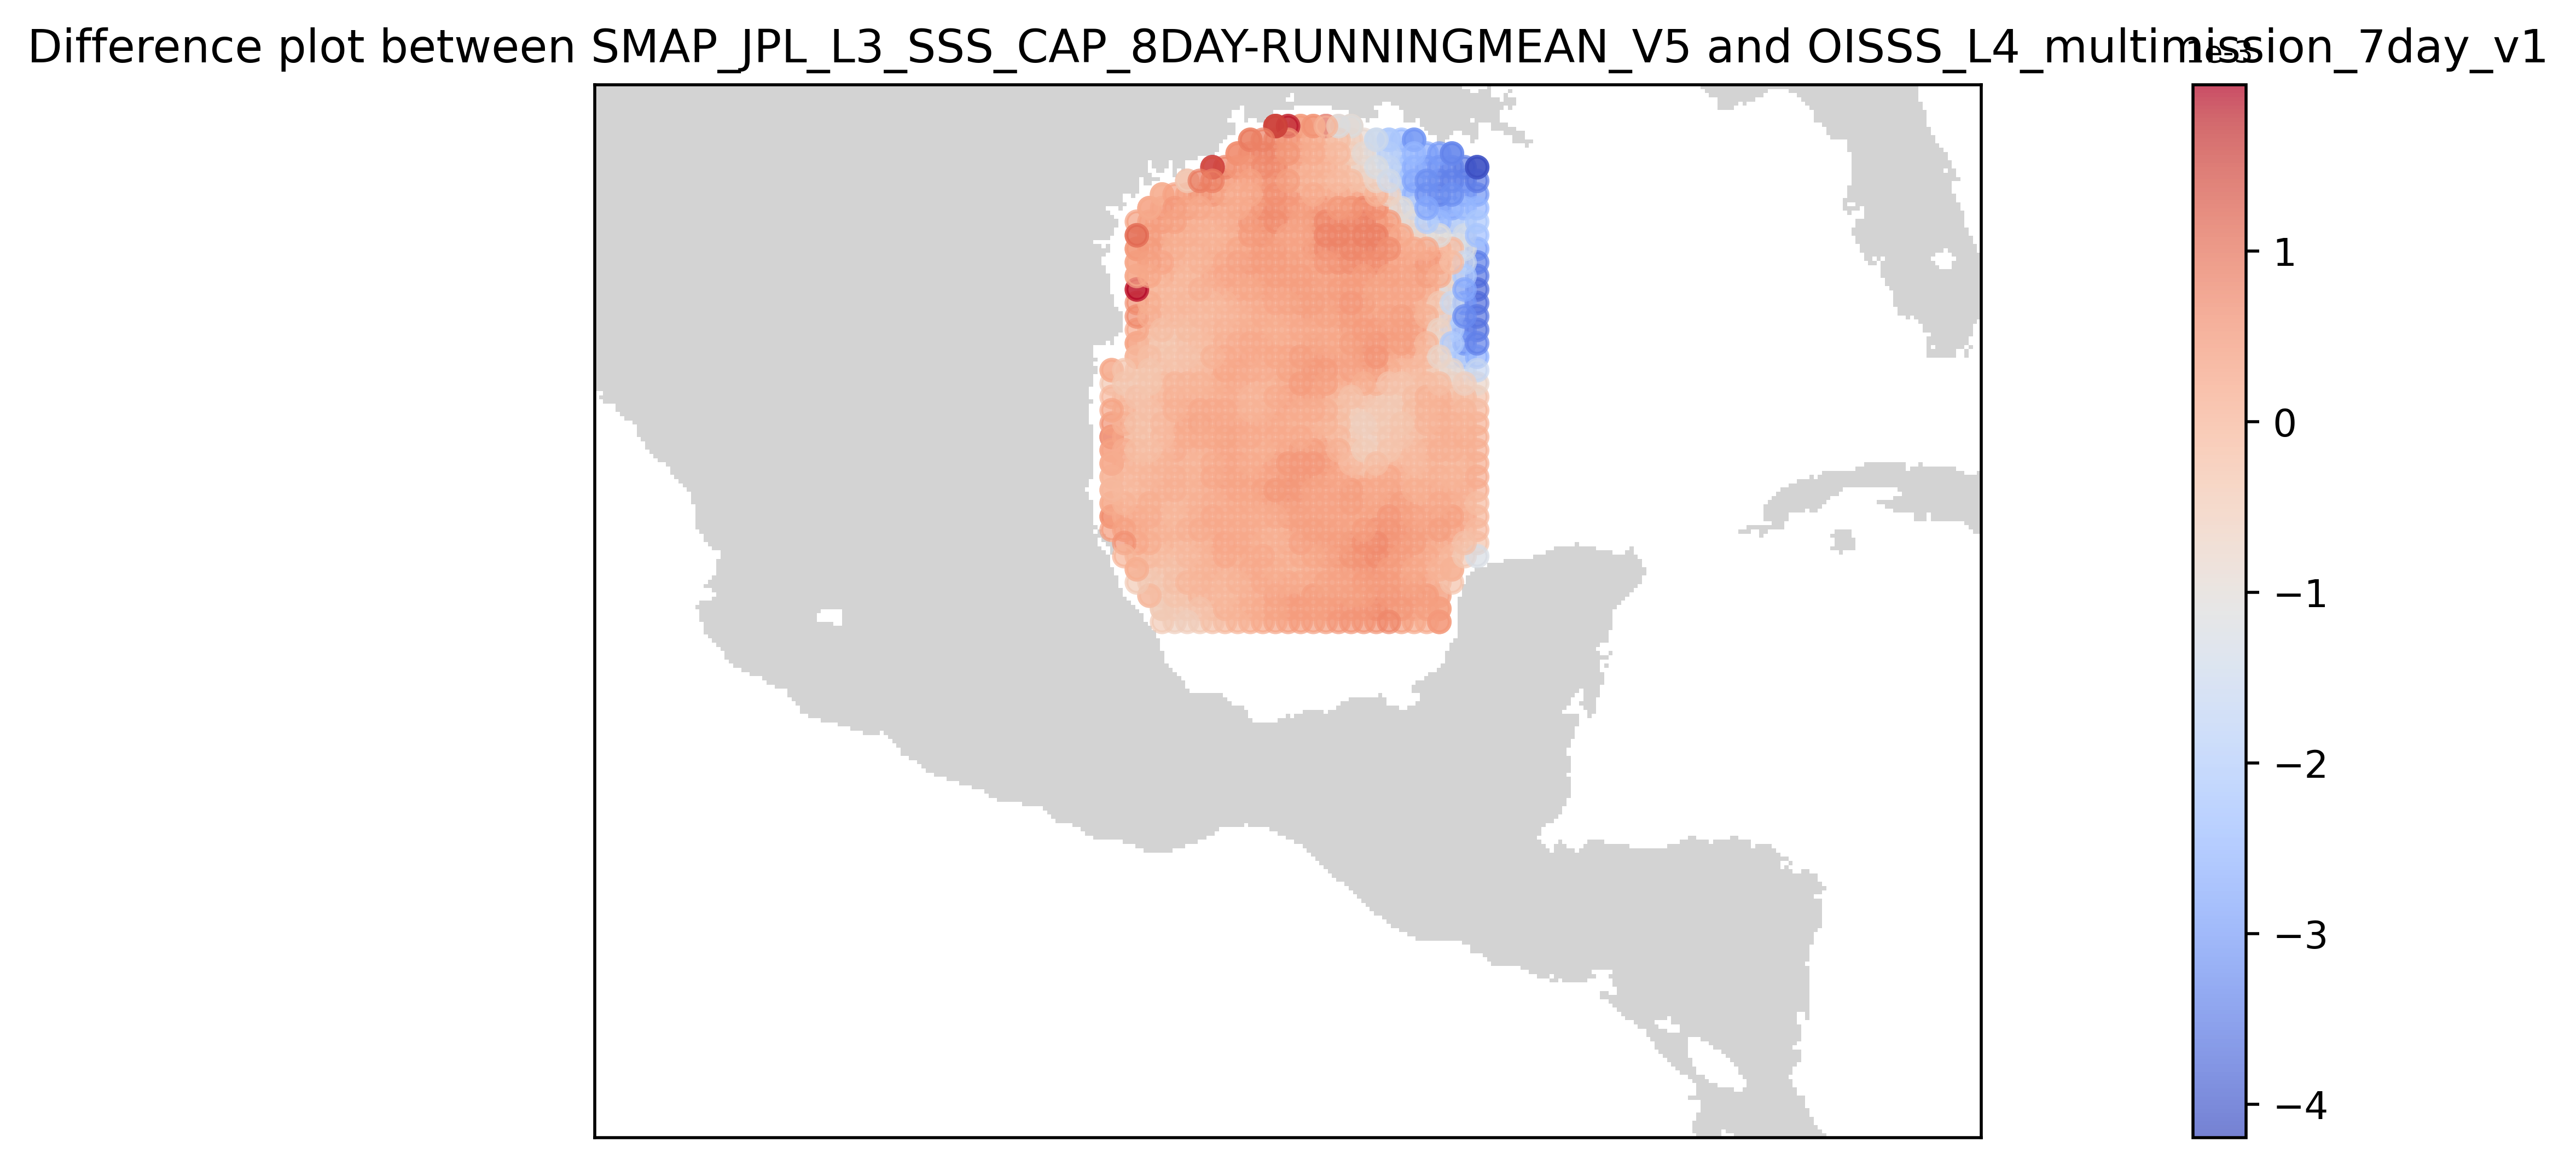

In [ ]:
generate_diff_plot(primary_points, secondary_points, query_params['primary'], query_params['secondary'], '1e-3')

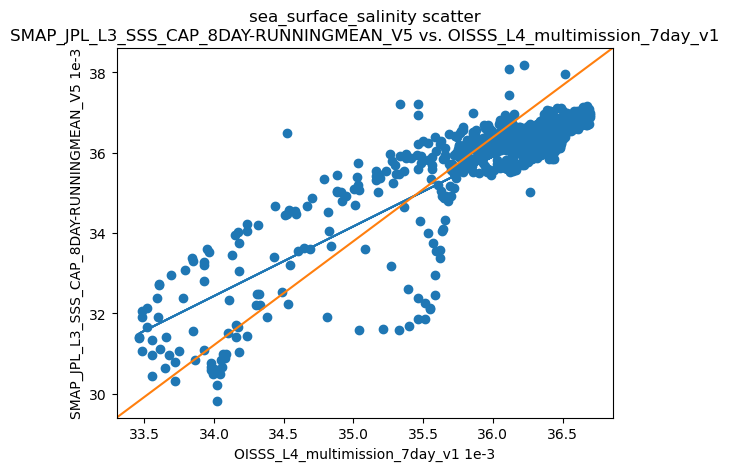

In [28]:
generate_scatter_plot(primary_points, secondary_points, query_params['primary'], query_params['secondary'], query_params['parameter'], '1e-3')

### Run satellite to satellite matchup query

Match ASCATB-L2-Coastal with MUR25-JPL-L4-GLOB-v04.2

In [29]:
query_params = {
    'primary': 'ASCATB-L2-Coastal',
    'secondary': 'MUR25-JPL-L4-GLOB-v04.2',
    'startTime': '2018-08-01T00:00:00Z',
    'endTime': '2018-08-02T00:00:00Z',
    'tt': 43200,  # Time tolerance in seconds
    'rt': 50000,  # Spatial tolerance in meters
    'b': '-100,20,-90,30',
    'platforms': '65',
    'depthMin': -20,
    'depthMax': 10,
    'matchOnce': 'true',
    'resultSizeLimit': 0
}

primary_points, secondary_points, execution_id = execute_matchup_request(query_params)

https://doms.jpl.nasa.gov/match_spark?primary=ASCATB-L2-Coastal&secondary=MUR25-JPL-L4-GLOB-v04.2&startTime=2018-08-01T00%3A00%3A00Z&endTime=2018-08-02T00%3A00%3A00Z&tt=43200&rt=50000&b=-100%2C20%2C-90%2C30&platforms=65&depthMin=-20&depthMax=10&matchOnce=true&resultSizeLimit=0
Execution ID: 0b589a99-b02f-482e-81d4-a29451073125
Total number of primary matched points 5527
Total number of secondary matched points 5527


In [30]:
df = fetch_result(execution_id, "NETCDF", "ascat_l2_to_mur_l4_results.nc", ["wind_speed", "wind_to_direction"], ["sea_surface_foundation_temperature"])
df

,PrimaryData_lon,PrimaryData_lat,PrimaryData_wind_speed,PrimaryData_wind_to_direction,PrimaryData_datetime,SecondaryData_lon,SecondaryData_lat,SecondaryData_sea_surface_foundation_temperature,SecondaryData_datetime
0,-92.46603,24.60072,4.56,345.00000,2018-08-01 02:57:04,-92.375,24.625,30.701996,2018-08-01 08:59:44
1,-92.84140,24.15560,4.11,340.20000,2018-08-01 02:57:04,-92.875,24.125,30.497986,2018-08-01 08:59:44
2,-90.34692,25.19338,7.79,349.10000,2018-08-01 15:23:44,-90.375,25.125,30.074005,2018-08-01 08:59:44
3,-95.43552,27.69839,2.44,250.60000,2018-08-01 02:59:12,-95.375,27.625,30.234009,2018-08-01 08:59:44
4,-92.55435,23.64396,2.42,266.30002,2018-08-01 02:57:04,-92.625,23.625,30.654999,2018-08-01 08:59:44
...,...,...,...,...,...,...,...,...,...
5522,-92.42194,20.27843,6.92,258.10000,2018-08-01 02:57:04,-92.375,20.375,29.980011,2018-08-01 08:59:44
5523,-94.03247,23.48297,3.23,265.80002,2018-08-01 02:57:04,-94.125,23.375,30.759003,2018-08-01 08:59:44
5524,-90.19012,26.53153,9.41,1.20000,2018-08-01 15:23:44,-90.125,26.625,29.962006,2018-08-01 08:59:44
5525,-93.30124,21.60541,9.62,27.50000,2018-08-01 15:23:44,-93.375,21.625,30.398010,2018-08-01 08:59:44
